# Predicting Car Prices

In this project, I will predict a car's market price using its attributes. The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. 

You can read more about the data set here (https://archive.ics.uci.edu/ml/datasets/automobile)
and can download it directly from here (https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data)

In [43]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import math
from matplotlib import pyplot

pd.options.display.max_columns = 99
%matplotlib inline  

In [5]:
cars = pd.read_csv('imports-85.data', names=[
    'symboling',
    'normalized-losses',
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-type',
    'num-of-cyclinders',
    'engine-size',
    'fuel-system',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
    'price'
])
print(cars.dtypes) #Determine which columns are numeric and can be used as features and which column is the target column
cars.head(5)

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cyclinders     object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cyclinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


From above we can see that there are 9 numeric column types in the dataset. The 'price' column is our target column that our machine learning algorithm will be trying to predict.

## Evaluate null values

Based on the data set preview from the last step, we can tell that the normalized-losses column contains missing values represented using "?". Let's replace these values and look for the presence of missing values in other numeric columns. Let's also rescale the values in the numeric columns so they all range from 0 to 1.

In [13]:
cars = cars.replace('?', np.nan) #Use the DataFrame.replace() method to replace all of the ? values with the numpy.nan missing value

numeric_columns = ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars_numeric_columns = cars[numeric_columns].copy()
cars_numeric_columns = cars_numeric_columns.astype(float) #convert columns to numeric types

In [14]:
#check for missing values
pd.isnull(cars_numeric_columns).sum()

symboling             0
normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [15]:
# Because `price` is the column we want to predict, let's remove any rows with missing `price` values.
cars_numeric_columns = cars_numeric_columns.dropna(subset=['price'])
cars_numeric_columns.isnull().sum()

symboling             0
normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [18]:
# Replace missing values in other columns using column means.
cars_numeric_columns = cars_numeric_columns.fillna(cars_numeric_columns.mean())

In [19]:
#check for missing values
pd.isnull(cars_numeric_columns).sum()

symboling            0
normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

## K-Nearest Neighbor Model

### Univariate

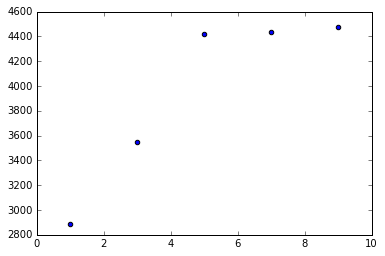

[2887.6471598864014, 3551.0101364103266, 4420.003293211443, 4433.75567874184, 4476.686877315731]


In [83]:
def knn_train_test(training_col_name, target_col_name, df, k):
    randomized_df = df.iloc[np.random.RandomState(seed=1).permutation(len(df))]
    #split the data set into a training and test set
    df_length = int(round((len(randomized_df)*.75), 0))
    training_set = randomized_df.iloc[0:df_length]
    test_set = randomized_df.iloc[df_length:]
    
    train_columns = [training_col_name]
    target_column = target_col_name
    
    #instantiate the KNeighborsRegressor class, fit the model on the training set, and make predictions on the test set
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', metric='euclidean')
    knn.fit(training_set[train_columns], training_set[target_column])
    predictions = knn.predict(test_set[train_columns])

    #calculate the RMSE and return that value
    mse = mean_squared_error(test_set[target_column],predictions)
    rmse = math.sqrt(mse) 
    return rmse
    
#For each numeric column, create, train, and test a univariate model using the following k values (1, 3, 5, 7, and 9)
rmse_list = []
k_values = [1,3,5,7,9]
for i in k_values:
    rmse_list.append(knn_train_test('wheel-base','price', cars_numeric_columns, i))

#Visualize the results using a scatter plot 
pyplot.scatter(k_values, rmse_list)
pyplot.show()
print(rmse_list)

Using a univariate model we can see that keeping k at 1 produced the lowest RMSE value at 4731. This will fluctuate, however, depending on how the train/test lists are randomly allocated. Here we set the random seed to 1 to get the same result if run again.

Looking at other columns more systematically we see these RMSE values:

In [85]:
rmse_results = {}
train_cols = cars_numeric_columns.columns.drop('price')

for col in train_cols:
    rmse_val = knn_train_test(col, 'price', cars_numeric_columns, 5)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

engine-size          3030.059103
highway-mpg          3570.152139
width                3830.539585
curb-weight          4047.052502
city-mpg             4080.456045
wheel-base           4420.003293
horsepower           4787.483489
length               5363.698430
compression-ratio    6058.663085
height               6113.236509
normalized-losses    6512.511099
bore                 6887.975776
symboling            7135.436831
peak-rpm             7299.150537
stroke               8306.528075
dtype: float64

Now, varying the k values for each column:

In [87]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = cars_numeric_columns.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', cars_numeric_columns)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 8602.58848450066,
  3: 6984.239489480916,
  5: 6795.388311535586,
  7: 6896.559499627726,
  9: 6882.822815090022},
 'city-mpg': {1: 5901.143574354764,
  3: 4608.180446380397,
  5: 4760.44984187731,
  7: 5218.847825621605,
  9: 5446.82446248222},
 'compression-ratio': {1: 8087.205346523092,
  3: 7375.063685578359,
  5: 6610.812153159129,
  7: 6732.801282941515,
  9: 7024.485525463435},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4445.141920375235,
  7: 4330.608104418053,
  9: 4632.92525121302},
 'engine-size': {1: 3258.4861059962027,
  3: 2951.5259704863593,
  5: 3271.449938331611,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'height': {1: 8751.160007407449,
  3: 8121.165102604576,
  5: 8073.1197593196175,
  7: 7693.302663098179,
  9: 7776.396862418894},
 'highway-mpg': {1: 6025.594966720739,
  3: 4671.390389789466,
  5: 4643.046277675214,
  7: 4792.485755925797,
  9: 5227.337381566373},
 'horsepower': {1: 4170.054848037801,
  3: 4020.105451002

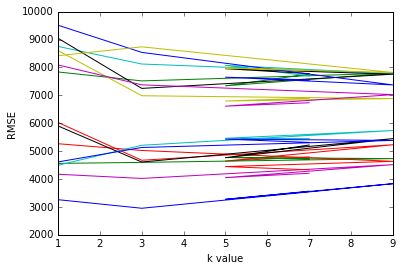

In [90]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    pyplot.plot(x,y)
    pyplot.xlabel('k value')
    pyplot.ylabel('RMSE')

### Multivariate

In [80]:
def knn_train_test(training_col_names, target_col_name, df, k):
    randomized_df = df.iloc[np.random.RandomState(seed=1).permutation(len(df))]
    #split the data set into a training and test set
    df_length = int(round((len(randomized_df)*.75), 0))
    training_set = randomized_df.iloc[0:df_length]
    test_set = randomized_df.iloc[df_length:]
    
    train_columns = training_col_names
    target_column = target_col_name
    
    #instantiate the KNeighborsRegressor class, fit the model on the training set, and make predictions on the test set
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', metric='euclidean')
    knn.fit(training_set[train_columns], training_set[target_column])
    predictions = knn.predict(test_set[train_columns])

    #calculate the RMSE and return that value
    mse = mean_squared_error(test_set[target_column],predictions)
    rmse = math.sqrt(mse) 
    return rmse


knn_train_test(list(cars_numeric_columns.drop(['price'], axis=1).columns), 'price', cars_numeric_columns, 5)

2736.002977629959

Using all of the columns we get an RMSE value of 2736. Now let's do it broken out by best RMSE values and step by step add more columns to see how that affects RMSE value:

In [92]:
# Compute average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

engine-size          3375.274641
horsepower           4191.699237
width                4674.698766
curb-weight          4739.056704
highway-mpg          5071.970954
length               5173.087449
city-mpg             5187.089230
wheel-base           5269.898315
compression-ratio    7166.073599
bore                 7232.319720
normalized-losses    7649.281809
stroke               7955.585214
height               8083.028879
peak-rpm             8124.022815
symboling            8167.734209
dtype: float64


In [94]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        cars_numeric_columns
    )

k_rmse_results

{'2 best features': {5: 2925.00464591321},
 '3 best features': {5: 2901.007254846714},
 '4 best features': {5: 3864.067381953533},
 '5 best features': {5: 3870.6838798617723},
 '6 best features': {5: 3872.2947119553833}}

Using the top 3 features produced the best RMSE value

## Hyperparameter Tuning

Let's now optimize the model that performed the best in the previous step.

In [98]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1,26)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,5):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        cars_numeric_columns
    )

k_rmse_results

{'2 best features': {1: 2832.6762159757077,
  2: 2592.760534757126,
  3: 2620.327691572396,
  4: 2824.6258095735284,
  5: 2925.00464591321,
  6: 3162.7465130445685,
  7: 3295.7806528253186,
  8: 3580.3376319325566,
  9: 3844.44037715117,
  10: 4066.955641740046,
  11: 4162.831387739917,
  12: 4250.9953344770765,
  13: 4288.279719198008,
  14: 4318.677524353425,
  15: 4384.634184404111,
  16: 4477.339380724929,
  17: 4542.7101905616355,
  18: 4675.594058904271,
  19: 4696.93629950144,
  20: 4684.844437694387,
  21: 4744.078137218994,
  22: 4779.969895724662,
  23: 4826.869687492047,
  24: 4881.349005863175,
  25: 4963.926213279482},
 '3 best features': {1: 2861.158731550683,
  2: 2644.428153665928,
  3: 2681.7457878865184,
  4: 2722.280458854013,
  5: 2901.007254846714,
  6: 3079.0995987640463,
  7: 3210.5192759138426,
  8: 3485.8385181559474,
  9: 3782.798641745253,
  10: 4029.356670465123,
  11: 4133.471835231293,
  12: 4225.481801502254,
  13: 4232.577904328598,
  14: 4309.0412427890

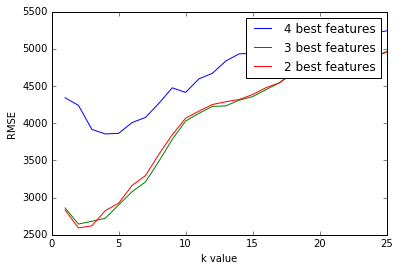

In [99]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())  
    plt.plot(x,y, label="{}".format(k))
    
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend()

We can see from above that a k-value of 2 seems to be most optimal.